## Analysis of job 733049: can the crowd distinguish the semantic relationship linking two concepts?

2015-06-04 Tong Shu Li

Let us examine how well the crowd performed on the semantic relationship determination task in CrowdFlower job #733049. As an initial test, 100 rows of data were processed, costing $42 USD. 

In [1]:
from __future__ import division

In [2]:
from collections import Counter
import pandas as pd
import pickle
import matplotlib as plt
import random

In [3]:
%matplotlib inline

In [4]:
random.seed("2015-06-08:14:14")

In [5]:
from src.filter_data import filter_data
from src.aggregate_votes import aggregate_votes

### Read the data:

In [6]:
settings = {
    "loc": "./data",
    "fname": "job_733049_full_with_untrusted_and_incomplete.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

raw_data = filter_data(settings)

In [7]:
raw_data.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,subject_desc,subject_end_index,subject_pref_name,subject_score,subject_start_index,subject_stype_desc,subject_stype_name,subject_text,uniq_id,user_confidence_gold
1,731283654,6/3/2015 23:01:27,False,1650715675,NaN,6/3/2015 22:59:38,False,neodev,0.8421,33018492,...,Continuous and profound contemplation or musin...,40,Meditation Therapy,0,30,"A procedure, method, or technique designed to ...",Therapeutic or Preventive Procedure,meditation,uniq_id_b0,NaN
4,731283654,6/3/2015 23:07:03,False,1650724185,NaN,6/3/2015 23:03:35,False,clixsense,0.7647,30260697,...,Continuous and profound contemplation or musin...,40,Meditation Therapy,0,30,"A procedure, method, or technique designed to ...",Therapeutic or Preventive Procedure,meditation,uniq_id_b0,NaN
5,731283654,6/3/2015 23:10:09,False,1650728578,NaN,6/3/2015 23:05:25,False,elite,0.7500,29825265,...,Continuous and profound contemplation or musin...,40,Meditation Therapy,0,30,"A procedure, method, or technique designed to ...",Therapeutic or Preventive Procedure,meditation,uniq_id_b0,NaN
6,731283654,6/3/2015 23:16:45,False,1650738417,NaN,6/3/2015 23:12:51,False,prodege,0.8125,9559045,...,Continuous and profound contemplation or musin...,40,Meditation Therapy,0,30,"A procedure, method, or technique designed to ...",Therapeutic or Preventive Procedure,meditation,uniq_id_b0,NaN
9,731283655,6/3/2015 22:59:30,False,1650712700,NaN,6/3/2015 22:55:17,False,clixsense,0.8750,31307491,...,Treatment with corticosteroid drugs to reduce ...,53,Steroid therapy,0,38,"A procedure, method, or technique designed to ...",Therapeutic or Preventive Procedure,steroid therapy,uniq_id_b1,NaN


### Total number of trusted judgements

In [8]:
len(raw_data)

419

### There were not very many comments:

In [9]:
raw_data["comments"].unique()

array([nan,
       'The phrase needs to be "impaired respiratory chain function" for any category to fit.'], dtype=object)

### Overall the crowd sentiment seems to be evenly distributed:

In [10]:
for choice, num in Counter(raw_data["user_confidence"]).most_common():
    print "Choice: {0}, # votes: {1}, {2}% of all votes".format(
        choice, num, num / len(raw_data) * 100)

Choice: confident, # votes: 181, 43.1980906921% of all votes
Choice: very_confident, # votes: 147, 35.0835322196% of all votes
Choice: not_very_confident, # votes: 91, 21.7183770883% of all votes


### Accuracy plot of everyone:

In [11]:
settings = {
    "loc": "./data",
    "fname": "job_733049_full_with_untrusted_and_incomplete.csv",
    "data_subset": "all",
    "min_accuracy": 0.0,
    "max_accuracy": 1.0
}

all_data = filter_data(settings)

#### We get a bell curve as expected:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc80e732950>]], dtype=object)

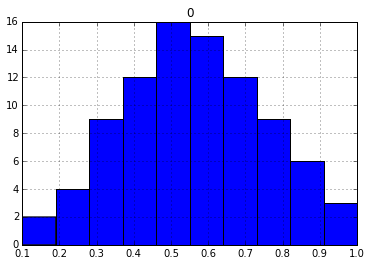

In [12]:
uniq_users = all_data["_worker_id"].unique()
trust = []
for user_id in uniq_users:
    sub = all_data.query("_worker_id == {0}".format(user_id))
    assert len(sub["_trust"].unique()) == 1
    trust.append(sub.iloc[0]["_trust"])
    
pd.DataFrame(trust).hist()

## Let's plot the accuracy scores of people who passed the test:

In [13]:
uniq_users = raw_data["_worker_id"].unique()

In [14]:
len(uniq_users)

12

In [15]:
trust = []
for user_id in uniq_users:
    sub = raw_data.query("_worker_id == {0}".format(user_id))
    assert len(sub["_trust"].unique()) == 1
    trust.append(sub.iloc[0]["_trust"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc80e786f10>]], dtype=object)

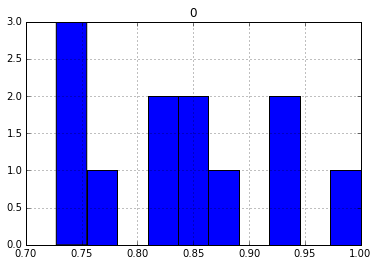

In [16]:
pd.DataFrame(trust).hist()

### Group by unique id, and aggregate the votes:

We want to know what the top crowd answer is for each question:

In [17]:
def aggregate_results(id_column, agg_column, data, match = None):
    result = []
    for identifier, group in data.groupby(id_column):
        ans = aggregate_votes(agg_column, group)

        total_vote_score = sum(ans["conf_score"])
        percent_agree = ans["conf_score"] / total_vote_score

        ans["percent_agree"] = percent_agree
        ans.insert(0, id_column, identifier)

        if match is not None:
            matches = [match(identifier, crowd_choice) for crowd_choice in ans[agg_column]]
            ans["match"] = matches

        ans = ans.sort(["conf_score"], ascending = False)

        result.append(ans)

    return pd.concat(result)

In [18]:
res = aggregate_results("uniq_id", "crowd_relation_type", raw_data)

In [19]:
res.head()

,uniq_id,crowd_relation_type,conf_score,num_votes,conf_skew_score,percent_agree
1,uniq_id_b0,functionally_related,1.5921,2,1,0.502351
0,uniq_id_b0,conceptually_related,1.5772,2,-1,0.497649
0,uniq_id_b1,functionally_related,3.3481,4,0,1.000000
0,uniq_id_b10,spatially_related,2.5879,3,0,1.000000
1,uniq_id_b100,spatially_related,3.4492,4,0,0.818529


### Read the mapping for each predicate to its top level relationship type:

In [20]:
with open("./data/ancestor.pickle", "rb") as fin:
    ancestor = pickle.load(fin)

### Now we can finally judge for each work unit, whether the top voted crowd answer matched that of the gold standard

In [21]:
matches = []
mismatches = []
for uniq_id, group in res.groupby("uniq_id"):
    crowd_rel_type = group.iloc[0]["crowd_relation_type"]
    
    sub = raw_data.query("uniq_id == '{0}'".format(uniq_id))
    
    assert len(sub["predicate"].unique()) == 1
    
    gold_pred = sub.iloc[0]["predicate"].lower()
    if gold_pred.startswith("neg"):
        gold_pred = gold_pred[4:]

    assert not gold_pred.startswith("neg")
    
    assert gold_pred in ancestor
    assert gold_pred != 'associated_with'
    
    # now we can check if the work units matched:
    if crowd_rel_type + "_to" == ancestor[gold_pred]:
        matches.append(uniq_id)
    else:
        mismatches.append(uniq_id)


## Results:

In [22]:
len(matches)

83

In [23]:
len(mismatches)

17

In [24]:
matches

['uniq_id_b1',
 'uniq_id_b10',
 'uniq_id_b100',
 'uniq_id_b101',
 'uniq_id_b102',
 'uniq_id_b103',
 'uniq_id_b104',
 'uniq_id_b106',
 'uniq_id_b107',
 'uniq_id_b11',
 'uniq_id_b13',
 'uniq_id_b14',
 'uniq_id_b15',
 'uniq_id_b16',
 'uniq_id_b17',
 'uniq_id_b18',
 'uniq_id_b2',
 'uniq_id_b20',
 'uniq_id_b21',
 'uniq_id_b24',
 'uniq_id_b25',
 'uniq_id_b27',
 'uniq_id_b3',
 'uniq_id_b31',
 'uniq_id_b32',
 'uniq_id_b34',
 'uniq_id_b35',
 'uniq_id_b36',
 'uniq_id_b37',
 'uniq_id_b38',
 'uniq_id_b39',
 'uniq_id_b41',
 'uniq_id_b42',
 'uniq_id_b43',
 'uniq_id_b44',
 'uniq_id_b45',
 'uniq_id_b46',
 'uniq_id_b47',
 'uniq_id_b48',
 'uniq_id_b49',
 'uniq_id_b5',
 'uniq_id_b50',
 'uniq_id_b52',
 'uniq_id_b53',
 'uniq_id_b54',
 'uniq_id_b56',
 'uniq_id_b57',
 'uniq_id_b59',
 'uniq_id_b6',
 'uniq_id_b60',
 'uniq_id_b62',
 'uniq_id_b63',
 'uniq_id_b64',
 'uniq_id_b65',
 'uniq_id_b66',
 'uniq_id_b67',
 'uniq_id_b70',
 'uniq_id_b71',
 'uniq_id_b72',
 'uniq_id_b73',
 'uniq_id_b74',
 'uniq_id_b75',
 'uniq

In [25]:
mismatches

['uniq_id_b0',
 'uniq_id_b12',
 'uniq_id_b19',
 'uniq_id_b22',
 'uniq_id_b23',
 'uniq_id_b26',
 'uniq_id_b28',
 'uniq_id_b29',
 'uniq_id_b33',
 'uniq_id_b55',
 'uniq_id_b58',
 'uniq_id_b61',
 'uniq_id_b68',
 'uniq_id_b69',
 'uniq_id_b7',
 'uniq_id_b86',
 'uniq_id_b97']

## Checking our work: did the crowd really get things right 83% of the time?

### How confident was the crowd for the questions that matched the gold standard?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc80e58e950>]], dtype=object)

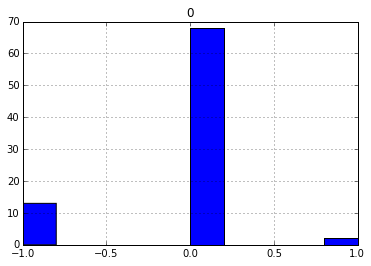

In [26]:
temp = []
for uniq_id in matches:
    data = res.query("uniq_id == '{0}'".format(uniq_id))
    temp.append(data.iloc[0]["conf_skew_score"])
    
pd.DataFrame(temp).hist()

### And the ones where they did not match the gold standard:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc80e377b90>]], dtype=object)

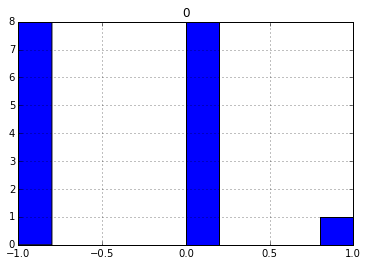

In [27]:
temp = []
for uniq_id in mismatches:
    data = res.query("uniq_id == '{0}'".format(uniq_id))
    temp.append(data.iloc[0]["conf_skew_score"])
    
pd.DataFrame(temp).hist()

It looks like the crowd is overall less confident in their top choice when they do not match the gold standard.

## Let's examine each work unit individually:

In [28]:
def summary(work_units):
    for uniq_id in work_units:
        data = res.query("uniq_id == '{0}'".format(uniq_id))
        sub = raw_data.query("uniq_id == '{0}'".format(uniq_id))

        print "Unique id: {0}".format(uniq_id)
        print "Work id: {0}".format(sub.iloc[0]["_unit_id"])
        print

        print "Gold: [{0}] {1} [{2}]".format(sub.iloc[0]["subject_pref_name"],
                                  sub.iloc[0]["predicate"],
                                  sub.iloc[0]["object_pref_name"])

        print

        gold = sub.iloc[0]["predicate"].lower()
        if gold.startswith("neg"):
            gold = gold[4:]

        print "{0}: {1}".format(gold, ancestor[gold])

        print
        print data
        print

        sentence = sub.iloc[0]["form_sent"]
        print sentence

        print "---------------------------------------------------------"
        print

In [29]:
summary(mismatches)

Unique id: uniq_id_b0
Work id: 731283654

Gold: [Meditation Therapy] ISA [Intervention regimes]

isa: conceptually_related_to

      uniq_id   crowd_relation_type  conf_score  num_votes  conf_skew_score  \
1  uniq_id_b0  functionally_related      1.5921          2                1   
0  uniq_id_b0  conceptually_related      1.5772          2               -1   

   percent_agree  
1       0.502351  
0       0.497649  

Findings suggest the value of <span class="subject_text">meditation</span> as an <span class="object_text">intervention</span> strategy with survivors and demonstrate the need for further research in this area.
---------------------------------------------------------

Unique id: uniq_id_b12
Work id: 731283666

Gold: [MASS PALPABLE] PROCESS_OF [Patients]

process_of: functionally_related_to

       uniq_id   crowd_relation_type  conf_score  num_votes  conf_skew_score  \
2  uniq_id_b12    physically_related      1.7981          2                0   
1  uniq_id_b12  functi

## After looking through the wrong answers, I concluded the following:

1. There were 2 work units which had special circumstances: b33 and b12. For b33, the gold standard was reversed, and the crowd choice under the reverse circumstances are correct. For b12, I would disagree with the gold standard and say that "palpable masses" are physical objects, and therefore the crowd answer of "palpable masses part of patients" is more representative of what the sentence is saying.

2. Next, I think the crowd got the following questions correct, despite not matching the gold standard: b97, b86, b7, b33, b29, b26, b19, b12. Some of these mismatches were due to the fact that I did not provide all the possible predicates to the crowd, and they therefore made the best interpretation they could. These discrepancies should disappear with further task iterations.

3. Finally, the ones the crowd did get wrong: b69, b68, b61, b58, b55, b28, b22, b23, b0. For these, the crowd didn't seem to understand what the sentence was saying, and therefore chose the wrong answers.

For work unit Unique id: uniq_id_b33 Work id: 731283687, the crowd identified the answer as "location of", which does not match the gold standard. However, if we look at the original xml file for the gold standard, we see that the text for the subject is "patients", whereas the preferredname for the subject is "single lesion". Therefore, the subject and object were flipped in the original data. Thus the crowd was not wrong; the data was bad.

### Randomly sample the ones which matched the gold standard:

In [30]:
summary(random.sample(matches, 10))

Unique id: uniq_id_b24
Work id: 731283678

Gold: [Respiratory Chain] AFFECTS [Aging]

affects: functionally_related_to

       uniq_id   crowd_relation_type  conf_score  num_votes  conf_skew_score  \
1  uniq_id_b24  functionally_related      1.6980          2               -1   
2  uniq_id_b24                 other      0.8750          1                0   
0  uniq_id_b24  conceptually_related      0.8421          1                1   

   percent_agree  
1       0.497204  
2       0.256215  
0       0.246581  

The main site for ROS production is the respiratory chain inside the mitochondria and accumulation of mtDNA mutations, and impaired <span class="subject_text">respiratory chain</span> function have been associated with degenerative diseases and <span class="object_text">aging</span>.
---------------------------------------------------------

Unique id: uniq_id_b63
Work id: 731283717

Gold: [Operative Surgical Procedures] TREATS [Small bowel obstruction NOS]

treats: functionall

# Note to self: there is a mistake in sentence presentation for uniq_id_b32. This arises because the subject and object overlap in the sentence, which I forgot to check for.

So, the small sample of the crowd's responses looks good. Overall, the recall was 91%, since the crowd matched the gold standard 83% of the time, and another 8% of the time they did not match, but performed properly according to the task they were given. Thus, it seems the crowd is relatively good at determining the semantic relationship.

One huge caveat is that the relationships given in the gold standard are mostly location of/isa relationships. Location of, process of, and part of make up 43% of the work units we showed to our crowd. Since these are relatively easy semantic relationships to determine, we should see how the crowd does on the hard relationships before we celebrate.

## Also, what was the distribution of the answers like? How well would the crowd have done if they just chose one answer all the time?

In [31]:
temp = []
for uniq_id, group in res.groupby("uniq_id"):
    temp.append(group.iloc[0]["crowd_relation_type"])
    
for k, n in Counter(temp).most_common():
    print k, n

functionally_related 56
spatially_related 17
conceptually_related 13
physically_related 12
temporally_related 1
other 1


In [32]:
len(res["uniq_id"].unique())

100

The crowd would get 56% agreement if they just chose "functional relationship" for each question. The crowd's distribution of top answers matches the distribution of the entire gold standard almost exactly.

### Here is the distribution of gold standard predicates for the sentences the crowd saw:

In [33]:
temp = []
for val, group in raw_data.groupby("uniq_id"):
    temp.append(group.iloc[0]["predicate"])

In [34]:
for v, n in Counter(temp).most_common():
    print v, n

TREATS 21
LOCATION_OF 17
PROCESS_OF 16
PART_OF 10
AFFECTS 8
ADMINISTERED_TO 5
INTERACTS_WITH 4
ISA 4
COEXISTS_WITH 3
USES 2
PRECEDES 2
METHOD_OF 1
NEG_PROCESS_OF 1
PRODUCES 1
MANIFESTATION_OF 1
NEG_DISRUPTS 1
AUGMENTS 1
DIAGNOSES 1
STIMULATES 1
